# Implementation of Linear Kalman Filter using Constant Acceleration Motion Model and Linear Measurement Model

In [137]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import expm
import scipy.integrate as integrate
from scipy.linalg import sqrtm
import sympy as sp
from sympy import init_printing
init_printing(use_latex=True)

In [172]:
# initalize global variables
dt = 0.01  # seconds
N = 100  # number of samples
qc = 0.1  # process noise magnitude
z_noise = 1  # measurement noise magnitude


## Available sensors:
1. GNSS, measuring x axis position, y axis position
2. Accelerometer, measuring x axis acceleration, y axis acceleration

## Motion Model: 
The general motion model equation for solving the linear optimal filtering problem is: \
\
$x_{k} = a_{k-1} \cdot x_{k-1} + q_{k-1}k$ \
\
For this project, $a_k$ is taken as the discretized constant acceleration model state transition matrix, $q_k$ is the discrete time process noise.

## Measurement Model:
The general measurement model equation for solving the linear optimal filtering problem is: \
\
$z_k = h_k \cdot x_k + r_k$ \
\
For this project, $h_k$ is taken as the linear measurement model measurement matrix, $r_k$ is the discrete time process noise.

## Kalman Filter:
The Kalman Filter is widely regarded as the best solution to the optimal filtering problem. When working with linear and gaussian variables, the Kalman Filter is able to provide the best possible estimate of the concerned state variables while accounting for uncertainties, noise and delays in the system. This is also possible when the state variables are internal and not directly measurable, but the physical relationships of the system are known through the motion model. \
\
This is achieved using the following steps:
1. Prediction \
    Assuming that the plant is a Markov process, ie, the future is only dependant on the present and not the past, we can predict the values of the state variables in the next time step using information from the current time step based on the known motion model.
2. Update \
    Assuming Gaussian variables, we can incorporate the new information from the current measurement and compute the Kalman gain, Innovation and Innovation Covariance, which along with knowledge of the measurement model, allows us to correct our prediction of the state variables. The Kalman gain provides us a way to quantify how much we trust our prediction or measurement after tuning the process noise accordingly.

## Kalman Filter Prediction Step:
1. $x_{k|k-1} = a_{k-1} \cdot x_{k-1|k-1}$
2. $P_{k|k-1} = a_{k-1} \cdot P_{k-1|k-1} \cdot a_{k-1}^T + q_{k-1}$

## Kalman Filter Update Step:
1. $k_k = P_{k|k-1} \cdot h_k^T \cdot s_k^{-1}$
2. $v_k = z_k - h_k \cdot x_{k|k-1}$
3. $s_k = h_k \cdot P_{k|k-1} \cdot h_k^T + r_k$
4. $x_{k|k} = x_{k|k-1} + k_{k} \cdot v_{k}$
5. $P_{k|k} = P_{k|k-1} - k_k \cdot s_k \cdot k_k^T$

In [139]:
px, py, vx, vy, ax, ay, T = sp.symbols('p_x p_y v_x v_y a_x a_y T')
states = sp.Matrix([px, py, vx, vy, ax, ay])
a = sp.Matrix([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
a = sp.exp(T * a)
gamma = sp.Matrix([[0.0], [0.0], [0.0], [0.0], [1.0], [1.0]])
q = qc * gamma @ np.transpose(gamma)
q_euler = T * q
q_exact = sp.integrate(sp.exp(T*a) * q * sp.exp(T*a.T), T)

## State Matrix ($x_k$):

In [140]:
states

⎡pₓ ⎤
⎢   ⎥
⎢p_y⎥
⎢   ⎥
⎢vₓ ⎥
⎢   ⎥
⎢v_y⎥
⎢   ⎥
⎢aₓ ⎥
⎢   ⎥
⎣a_y⎦

In [144]:
# prior mean
x_0 = np.array([[0.0],  # x position
                [0.0],  # y position
                [0.0],  # x velocity
                [0.0],  # y velocity
                [0.0],  # x acceleration
                [0.0]  # y acceleration
                ])

# prior covariance
p_0 = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

# a matrix - discrete time motion model
a = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

a = expm(dt * a)

## State Transition Matrix ($a$):

In [141]:
a

⎡                 2        ⎤
⎢1  0  T  0  0.5⋅T     0   ⎥
⎢                          ⎥
⎢                         2⎥
⎢0  1  0  T    0     0.5⋅T ⎥
⎢                          ⎥
⎢0  0  1  0  1.0⋅T     0   ⎥
⎢                          ⎥
⎢0  0  0  1    0     1.0⋅T ⎥
⎢                          ⎥
⎢0  0  0  0   1.0      0   ⎥
⎢                          ⎥
⎣0  0  0  0    0      1.0  ⎦

In [145]:
# q matrix - continuous time process noise covariance
gamma = np.array([[0.0], [0.0], [0.0], [0.0], [1.0], [1.0]])
q = qc * gamma @ np.transpose(gamma)
q_euler = dt * q


# h matrix - measurement model
h = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])


# r matrix - measurement noise covariance
r = np.array([[0.010, 0.0, 0.0, 0.0],
              [0.0, 0.015, 0.0, 0.0],
              [0.0, 0.0, 0.1, 0.0],
              [0.0, 0.0, 0.0, 0.1]])**2

## Process Noise ($q$):

In [142]:
q_euler

⎡0  0  0  0    0      0  ⎤
⎢                        ⎥
⎢0  0  0  0    0      0  ⎥
⎢                        ⎥
⎢0  0  0  0    0      0  ⎥
⎢                        ⎥
⎢0  0  0  0    0      0  ⎥
⎢                        ⎥
⎢0  0  0  0  0.1⋅T  0.1⋅T⎥
⎢                        ⎥
⎣0  0  0  0  0.1⋅T  0.1⋅T⎦

In [143]:
q_exact

⎡    ⎛        8          7        6        5         4        3         2     
⎢1.0⋅⎝0.0125⋅T  - 0.025⋅T  + 0.1⋅T  - 0.3⋅T  + 0.75⋅T  - 1.5⋅T  + 2.25⋅T  - 2.
⎢                                                                             
⎢    ⎛        8          7        6        5         4        3         2     
⎢1.0⋅⎝0.0125⋅T  - 0.025⋅T  + 0.1⋅T  - 0.3⋅T  + 0.75⋅T  - 1.5⋅T  + 2.25⋅T  - 2.
⎢                                                                             
⎢           ⎛       6         5          4         3          2               
⎢       1.0⋅⎝0.025⋅T  - 0.05⋅T  + 0.125⋅T  - 0.25⋅T  + 0.375⋅T  - 0.375⋅T + 0.
⎢                                                                             
⎢           ⎛       6         5          4         3          2               
⎢       1.0⋅⎝0.025⋅T  - 0.05⋅T  + 0.125⋅T  - 0.25⋅T  + 0.375⋅T  - 0.375⋅T + 0.
⎢                                                                             
⎢                    ⎛       4          3           

In [146]:
# linear kalman filter
def kalman_filter(x, p, z):
    x_pred, p_pred = linear_prediction(a, x, p, q_euler)
    x_upd, p_upd = linear_update(x_pred, p_pred, z, h, r)
    return x_upd, p_upd

In [147]:
# linear kalman filter prediction step
def linear_prediction(a, x_hat, p_hat, q):
    x_pred = a @ x_hat
    p_pred = a @ p_hat @ np.transpose(a) + q
    return x_pred, p_pred

In [148]:
# linear kalman filter update step
def linear_update(x_hat, p_hat, y, h, r):
    s = h @ p_hat @ np.transpose(h) + r
    k = p_hat @ np.transpose(h) @ np.linalg.pinv(s)
    v = y - h @ x_hat

    x_upd = x_hat + k @ v
    p_upd = p_hat - k @ s @ np.transpose(k)
    return x_upd, p_upd

In [149]:
# generate ground truth position x_true and noisy position z
def gen_measurement(i):
    x_true = np.array([[i], [i], [0.0], [0.0]])
    z = x_true + z_noise * np.random.randn(4, 1)
    return z, x_true

In [152]:
# run the kalman filter
x_est = x_0
p_est = p_0
x_true_cat = np.array([x_0[0, 0], x_0[1, 0]])
x_est_cat = np.array([x_0[0, 0], x_0[1, 0]])
z_cat = np.array([x_0[0, 0], x_0[1, 0]])
for i in range(N):
    z, x_true = gen_measurement(i)
    x_est, p_est = kalman_filter(x_est, p_est, z)
    x_true_cat = np.vstack((x_true_cat, np.transpose(x_true[0:2])))
    z_cat = np.vstack((z_cat, np.transpose(z[0:2])))
    x_est_cat = np.vstack((x_est_cat, np.transpose(x_est[0:2])))
print('KF Over')

KF Over


## Ground Truth Trajectory, Noisy Measurements, Estimated Trajectory: 

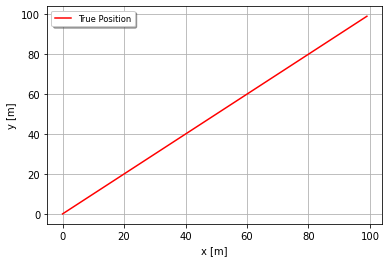

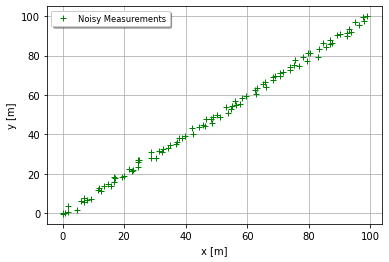

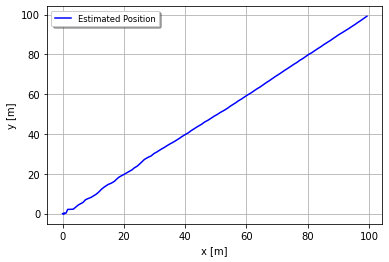

In [170]:
fig = plt.figure()
f = fig.add_subplot(111)
f.plot(x_true_cat[0:, 0], x_true_cat[0:, 1], 'r', label='True Position')
f.set_xlabel('x [m]')
f.set_ylabel('y [m]')
f.legend(loc='upper left', shadow=True, fontsize='small')
plt.grid(True)

fig = plt.figure()
f = fig.add_subplot(111)
f.plot(z_cat[0:, 0], z_cat[0:, 1], '+g', label='Noisy Measurements')
f.set_xlabel('x [m]')
f.set_ylabel('y [m]')
f.legend(loc='upper left', shadow=True, fontsize='small')
plt.grid(True)

fig = plt.figure()
f = fig.add_subplot(111)
f.plot(x_est_cat[0:, 0], x_est_cat[0:, 1], 'b', label='Estimated Position')
f.set_xlabel('x [m]')
f.set_ylabel('y [m]')
f.legend(loc='upper left', shadow=True, fontsize='small')
plt.grid(True)

plt.show()

## Estimated Trajectory:

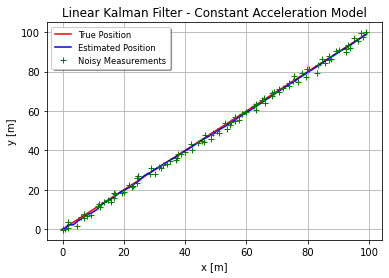

In [171]:
fig = plt.figure()
f = fig.add_subplot(111)
f.plot(x_true_cat[0:, 0], x_true_cat[0:, 1], 'r', label='True Position')
f.plot(x_est_cat[0:, 0], x_est_cat[0:, 1], 'b', label='Estimated Position')
f.plot(z_cat[0:, 0], z_cat[0:, 1], '+g', label='Noisy Measurements')
f.set_xlabel('x [m]')
f.set_ylabel('y [m]')
f.set_title('Linear Kalman Filter - Constant Acceleration Model')
f.legend(loc='upper left', shadow=True, fontsize='small')
plt.grid(True)
plt.show()